# 30x4-fold Cross Validation with preselected hyperparameters

The Figures generated in this notebook are shown in the final manuscript.

### Comparing the performance of ML classifiers and Consensus strategies

- This notebook performs the $30 \times 4 cv$ analysis using the [previously selected hyperparameters](./1_Hyperparameter_tuning_stage.ipynb).
    - The procedure involves performing 30 repetitions of 4-fold cross-validation using the whole dataset.
    - As a result 120 ($30\times4$) validation sets are generated.
        - Each validation set comprises 25% of the whole dataset (1-fold).
        - The indices of the molecules (samples/examples) that compose each validation set are saved into a file for further analysis.
    - 120  instances of the given ML algorithm are evaluated over their respective validation set.
    - The consensus scoring strategies are also applied over the validation sets.
    - The Friedman test is performed comparing the results of each SBVS method (ML vs consensus strategies).
    - Nemenyi *post-hoc* test is performed pair-wise comparisons between SBVS methods.
        - Critical Difference plots allow to visualize this results.
        - Heat map figures show the $p-values$ resulting from the Nemenyi *post-hoc* test.
    - Violin-box plots show the results of the ($30\times4$) analysis.
- Plots were generated using `ggplot2`

In [30]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../..')
from helper_modules.run_or_load import run_or_load_joblib
from helper_modules.plotting_metrics import PlotMetric
from helper_modules.friedman_and_nemenyi_test import *
%run ../../helper_modules/Helper_functions_for_nRepeats_x_kCV.ipynb

In [2]:
import warnings
warnings.filterwarnings('ignore')
# To avoid warnings related to `STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.` 

### Load docking results

In [3]:
# Define the same `random_state` for all the splits
RANDOM_STATE = 1

In [4]:
protein_name = 'hsp90'

In [5]:
file_name = '../4_Ensemble_docking_results/' + \
            'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
df_dk_res = pd.read_pickle(file_name)

# Extract the features columns: Docking scores
X = df_dk_res.drop('activity', axis = 1).values
# Extract the response variable: Activity
y = df_dk_res['activity'].values

X.shape

(2302, 64)

- Compute the proportion of active molecules ($R_a$) of the whole dataset.

In [6]:
R_a = round(y.sum() / len(y), 4)
print(f'Ratio of actives {y.sum()}/{len(y)}:')
R_a

Ratio of actives 256/2302:


0.1112

### Machine Learning Classifiers

- Define the ML algorithms with the preselected hyperparameters.

#### Dummy Classifier

In [7]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

#### Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C'        : 1.0, 
            'penalty'  : 'l2', 
            'solver'   : 'lbfgs', 
            'max_iter' : 400}
lr = LogisticRegression(**hyparams)

#### Gradient Boosting Trees

In [9]:
from xgboost import XGBClassifier

hyparams = {
     'subsample'        : 0.6,
     'n_estimators'     : 500,
     'max_depth'        : 5,
     'learning_rate'    : 0.05,
     'gamma'            : 0.01,
     'colsample_bytree' : 0.5,
     'alpha'            : 0.1,
     'eval_metric'      :   'logloss',
     'use_label_encoder': False
    }

xgb = XGBClassifier(**hyparams)

#### Dictionary of ML classifiers

In [10]:
# ML Classifiers
ml_classifiers = {
    'ml_lr'  : lr,
    'ml_xgb' : xgb,
    'ml_dclf': dclf
}

### Consensus Strategies

In [11]:
from helper_modules.consensus_strategies import \
    get_mean_score, get_min_score, get_geom_mean_score

In [12]:
cs_functions = {
    'cs_MEAN': get_mean_score,
    'cs_GEOM': get_geom_mean_score,
    'cs_MIN' : get_min_score
}

### SBVS methods (estimators) dictionary

In [13]:
estimators = {**ml_classifiers, **cs_functions}

In [14]:
# Map new names for each VS method, for plotting
full_names = ['LR', 'GBT', 'DClf', 
              'csAVG', 'csGEO', 'csMIN']
sbvs_names = dict(zip(
    estimators.keys(),
    full_names))
sbvs_names

{'ml_lr': 'LR',
 'ml_xgb': 'GBT',
 'ml_dclf': 'DClf',
 'cs_MEAN': 'csAVG',
 'cs_GEOM': 'csGEO',
 'cs_MIN': 'csMIN'}

### Evaluation metrics

In [15]:
metrics = dict(
    # AUC-ROC
    roc_auc   = {'metric_name': 'roc_auc'},
    # Normalized Enrichment Factor
    nef_Ra = {'metric_name': 'ef', 
              'fraction'   : R_a, 
              'method'     : 'normalized'}
    )

## 30x4 Cross validation

In [16]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [17]:
# ********************
# Perform the 30x4 CV
# ********************

n_repeats = 30
n_splits  = 4
evaluation_name = f'{n_repeats}x{n_splits}cv'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename = f'./cachedir/{evaluation_name}_{protein_name}',
    estimators = estimators, 
    X = X,
    y = y, 
    metrics   = metrics, 
    n_repeats = n_repeats, 
    n_splits  = n_splits,
    y_preds_return = True,
    random_state   = RANDOM_STATE
)

# Rename columns 
cv30x4 = cv30x4.rename(columns = sbvs_names)

File loaded: ./cachedir/30x4cv_hsp90


In [18]:
cv30x4.to_csv(f'./cv30x4_{protein_name}.csv')

### Compute the Single-Conformation Performances (SCP)

In [19]:
%%time
# **********************************
# Extract the individual predictions
# **********************************
# Single conformation performance SCP reference values

# Use the same `random_state` value to parse to `RepeatedStratifiedKFold`
filename = f'./cachedir/SCP_values_randState_{RANDOM_STATE}_{protein_name}'
scp_values = n_reps_k_folds_SCP_SAVE(
                    filename = filename,
                    metrics = metrics,
                    X = X, y = y, 
                    n_splits  = n_splits, 
                    n_repeats = n_repeats,
                    random_state = RANDOM_STATE
                   )

# Report the values
for m, values in scp_values.items():
    print(f'SCP values of {m} => ' + 
          f'mean: {values[0]:.2f} +/- {values[1]:.2f}, ' + 
          f'max: {values[2]:.2f}')

File loaded: ./cachedir/SCP_values_randState_1_hsp90
SCP values of roc_auc => mean: 0.55 +/- 0.06, max: 0.71
SCP values of nef_Ra => mean: 0.18 +/- 0.06, max: 0.41
CPU times: user 1.84 ms, sys: 2.42 ms, total: 4.26 ms
Wall time: 2.38 ms


<p style='color: black; background-color: #F9E5AB; padding: 5px;'>
    We will use <b>R</b> for plotting
</p>

In [20]:
%load_ext rpy2.ipython

### AUC-ROC Results

In [21]:
# **********************
# Descriptive Statistics
# **********************

# ROC-AUC
metric_name='roc_auc'
df_R = order_df(cv30x4, 
                metric_name).loc[metric_name]
scp_values_R = list(scp_values[metric_name])
# Descriptive statistics
report_descriptive_stats(cv30x4, metric_name)

Meadians:


,DClf,csGEO,csAVG,csMIN,LR,GBT
medians,0.49598,0.565065,0.5741,0.60085,0.808935,0.85728


IQRs:


,DClf,csGEO,csAVG,csMIN,LR,GBT
IQRs,0.03027,0.04409,0.04664,0.0522,0.03487,0.03215


Normality test results (Sahpiro-Wilk):


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,1,1,1,1,1


Friedman Test:


,chi^2,dof,p_value
Friedman Test,572.819048,5,1.506752e-121


In [22]:
%%R
full_names <- c('LR', 'GBT', 'DClf', 
                'csAVG', 'csGEO', 'csMIN')
cbbPalette <- c('#785EF0', '#3F93D2', '#44AA99', 
                '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

R[write to console]: Registering fonts with R

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: ggplot2

R[write to console]: 
Attaching package: ‘matrixStats’


R[write to console]: The following object is masked from ‘package:dplyr’:

    count


R[write to console]: The following object is masked from ‘package:plyr’:

    count


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Co

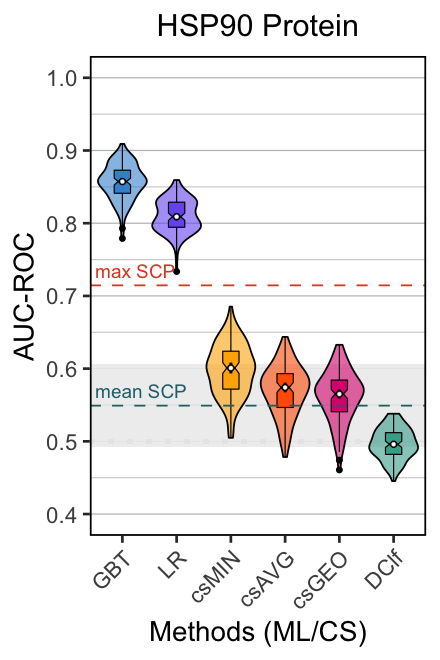

In [23]:
%%R  -i df_R -i scp_values_R -i protein_name -w 2.2 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')

metric <- 'AUC-ROC'
p = plot_violin(df = df_R, 
                cbbPalette = cbbPalette,
                decreasing_order = TRUE, 
                y_min=0.4, y_max=1,
                dot_size = 4, scale='width', 
                violin_width=0.9,
                scp_values_R = scp_values_R
               ) +
ggtitle(paste(toupper(protein_name), 'Protein'))


# Save the picture
methodology <- '30x4CV'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, 
                   paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

quartz_off_screen 
                2 


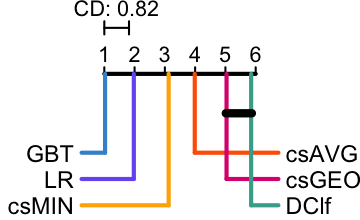

In [24]:
%%R -i df_R -i full_names -i protein_name -w 1.8 -h 1.1 --units in -r 200

source('../../R_scripts/plot_Critical_Difference.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'AUC-ROC'
plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)

# Save the figure
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)
dev.off()

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



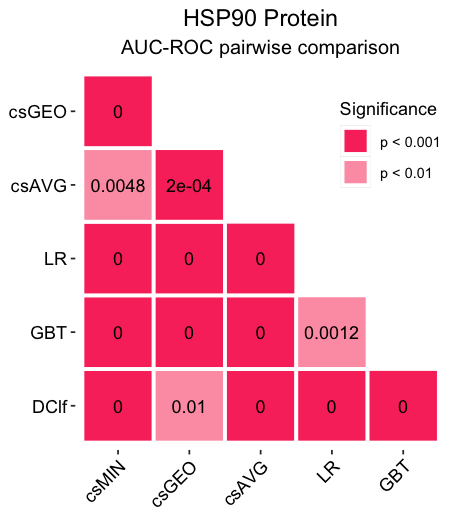

In [25]:
%%R -i df_R -i protein_name -w 3.5 -h 4 --units in -r 130

source('../../R_scripts/plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'AUC-ROC'
p = plot_p_vals_heatmap(df_R) +
labs(title = paste(toupper(protein_name), 'Protein'), 
     subtitle = paste(metric, "pairwise comparison"))

# Save the picture
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, 
                   paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)

p

### NEF Results

In [26]:
# **********************
# Descriptive Statistics
# **********************

# NEF
metric_name='nef_Ra'
df_R = order_df(cv30x4, 
                metric_name).loc[metric_name]

scp_values_R = list(scp_values[metric_name])
# Descriptive statistics
report_descriptive_stats(cv30x4, metric_name)

Meadians:


,DClf,csGEO,csAVG,csMIN,LR,GBT
medians,0.10938,0.20312,0.20312,0.21875,0.45312,0.53125


IQRs:


,DClf,csGEO,csAVG,csMIN,LR,GBT
IQRs,0.04688,0.05469,0.04688,0.0625,0.04687,0.0625


Normality test results (Sahpiro-Wilk):


,LR,GBT,DClf,csAVG,csGEO,csMIN
Normality,1,1,1,1,1,1


Friedman Test:


,chi^2,dof,p_value
Friedman Test,522.470238,5,1.125724e-110


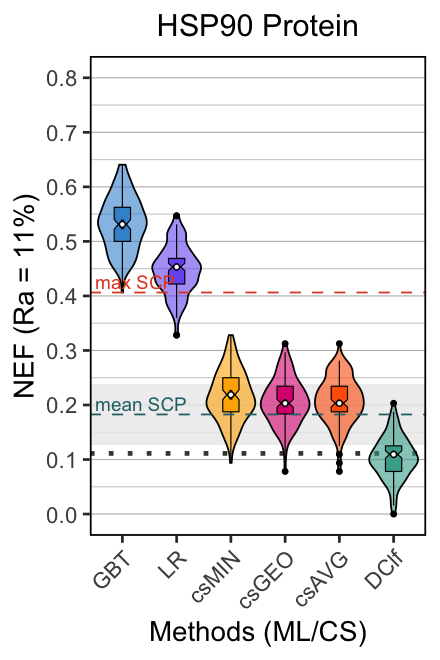

In [27]:
%%R  -i df_R -i scp_values_R -i R_a -i protein_name -w 2.2 -h 3.3 --units in -r 200

source('../../R_scripts/plot_violinBox.R')

metric <- 'NEF'
p = plot_violin(df = df_R, 
                cbbPalette = cbbPalette,
                y_min = 0.0, y_max = 0.8,
                base_h_line = R_a,
                y_label = paste0(metric, ' (Ra = ', round(R_a,2) *100 ,'%)'),
                scp_values_R = scp_values_R
               ) +
ggtitle(paste(toupper(protein_name), 'Protein'))


# Save the picture
methodology <- '30x4CV'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, 
                   paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

quartz_off_screen 
                2 


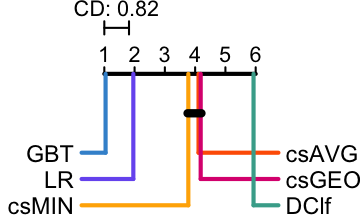

In [28]:
%%R -i df_R -i full_names -i protein_name -w 1.8 -h 1.1 --units in -r 200

source('../../R_scripts/plot_Critical_Difference.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'NEF'
plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)

# Save the figure
methodology <- '30x4CV'
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plot_Critical_Difference_color(df_R, 
             alpha = 0.01, cex = .65, 
             labels.cex = 0.7, 
             colPalette = cbbPalette, 
             side_marging = 10)
dev.off()

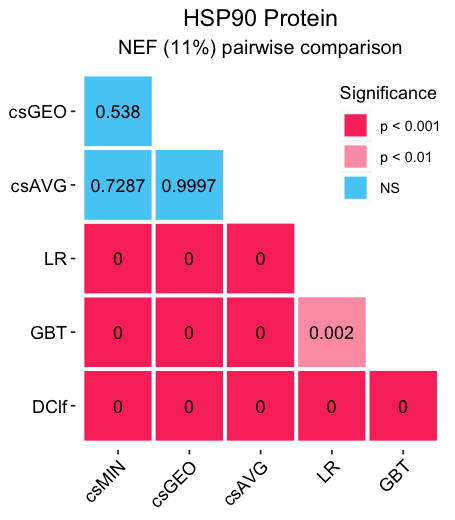

In [29]:
%%R -i df_R -i protein_name -i R_a -w 3.5 -h 4 --units in -r 130

source('../../R_scripts/plot_p_vals_heatmap.R')
df_R = df_R %>%
    mutate_all(round, 3)
metric <- 'NEF'
p = plot_p_vals_heatmap(df_R) +
labs(title = paste(toupper(protein_name), 'Protein'), 
     subtitle = paste0(metric, " (", round(R_a, 2) * 100,"%) pairwise comparison"))

# Save the picture
save_path = '~/Documents/Doctorado/Paper_doctorado/Response_to_reviewers/Figuras_mayor_review/raw_imgs/'
filename <- paste0(save_path, 
                   paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)

p

Finished!